## 1. Setup and Installation

First, let's install dependencies and import required libraries.

In [1]:
# Install dependencies (uncomment if running in Colab)
# !pip install timm==0.6.13 transformers==4.29.2 albumentations==1.3.1 yacs==0.1.8
# !pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

# Set style (using compatible style)
try:
    plt.style.use('seaborn-darkgrid')
except:
    plt.style.use('default')
    
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 1.12.1.post201
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060


## 2. Download Model and Setup Paths

For Colab users: Upload the model checkpoint and sample data, or use the provided download links.

In [2]:
import os
import sys

# Configuration
MODEL_PATH = '../experiments/training_20251119-095340/20251119-095356/models/best_model_97.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# If running in Colab, uncomment and modify:
# from google.colab import drive
# drive.mount('/content/drive')
# MODEL_PATH = '/content/drive/MyDrive/DermFormer/best_model_97.pth'

print(f"Using device: {DEVICE}")
print(f"Model path: {MODEL_PATH}")
print(f"Model exists: {os.path.exists(MODEL_PATH)}")

Using device: cuda
Model path: ../experiments/training_20251119-095340/20251119-095356/models/best_model_97.pth
Model exists: True


## 3. Define DermFormer Architecture

The model architecture consists of:
1. **NeST Backbones**: Separate encoders for clinical and dermoscopic images
2. **TabTransformer**: Processes patient metadata
3. **Cross-Attention Fusion**: Integrates information across modalities
4. **Entropy-Weighted Ensemble**: Combines predictions based on confidence

In [3]:
# Add model code path
sys.path.insert(0, '..')

from models.DermFormer import DermFormer
from models.NesT.nest_cli import nest_cli
from models.NesT.nest_der import nest_der
from models.NesT.nest_multimodalconcat import nest_MMC

# Initialize model
model = DermFormer(num_classes=5, hidden_dim=256).to(DEVICE)

# Load trained weights
if os.path.exists(MODEL_PATH):
    checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint)
    model.eval()
    print("Model loaded successfully!")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
else:
    print("Model checkpoint not found. Please upload the model file.")

[Warning] Fused window process have not been installed. Please refer to get_started.md for installation.
Tutel has not been installed. To use Swin-MoE, please install Tutel; otherwise, just ignore this.
Model loaded successfully!
Total parameters: 55,194,328
Trainable parameters: 55,194,328


## 4. Preprocessing Pipeline

Define image transformations and metadata encoding.

In [4]:
# Image preprocessing
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Metadata encodings (from Derm7pt dataset)
METADATA_ENCODINGS = {
    'elevation': {'flat': 0, 'raised': 1, 'unknown': 2},
    'sex': {'male': 0, 'female': 1, 'unknown': 2},
    'location': {
        'back': 0, 'lower extremity': 1, 'abdomen': 2, 'face': 3,
        'chest': 4, 'upper extremity': 5, 'scalp': 6, 'neck': 7, 'unknown': 8
    },
    'lesion_type': {'typical': 0, 'atypical': 1},
    'age_group': {'<30': 0, '30-50': 1, '>50': 2}
}

DIAGNOSIS_LABELS = {
    0: 'Basal Cell Carcinoma',
    1: 'Nevus',
    2: 'Melanoma',
    3: 'Miscellaneous',
    4: 'Seborrheic Keratosis'
}

TASK_LABELS = {
    'diag': 'Diagnosis',
    'pn': 'Pigment Network',
    'bwv': 'Blue-Whitish Veil',
    'vs': 'Vascular Structures',
    'pig': 'Pigmentation',
    'str': 'Streaks',
    'dag': 'Dots and Globules',
    'rs': 'Regression Structures'
}

def preprocess_image(image_path):
    """Load and preprocess an image."""
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    transformed = transform(image=img_np)
    return transformed['image'], img_np

def encode_metadata(elevation='unknown', sex='unknown', location='unknown', 
                    lesion_type='typical', age_group='30-50'):
    """Encode metadata into categorical tensor."""
    meta_cat = torch.tensor([
        METADATA_ENCODINGS['elevation'].get(elevation, 2),
        METADATA_ENCODINGS['sex'].get(sex, 2),
        METADATA_ENCODINGS['location'].get(location, 8),
        METADATA_ENCODINGS['lesion_type'].get(lesion_type, 0),
        METADATA_ENCODINGS['age_group'].get(age_group, 1)
    ]).unsqueeze(0).long()
    meta_con = torch.empty((1, 0)).long()
    return meta_cat, meta_con

print("Preprocessing pipeline ready!")

Preprocessing pipeline ready!


## 5. Inference Function

Run the model and extract all predictions.

In [5]:
def predict(clinical_img_path, dermoscopic_img_path, metadata_dict):
    """
    Run inference on a skin lesion case.
    
    Args:
        clinical_img_path: Path to clinical image
        dermoscopic_img_path: Path to dermoscopic image
        metadata_dict: Dictionary with keys: elevation, sex, location, lesion_type, age_group
    
    Returns:
        Dictionary containing predictions for all tasks and branches
    """
    # Preprocess images
    cli_tensor, cli_img = preprocess_image(clinical_img_path)
    der_tensor, der_img = preprocess_image(dermoscopic_img_path)
    
    # Encode metadata
    meta_cat, meta_con = encode_metadata(**metadata_dict)
    
    # Move to device
    cli_tensor = cli_tensor.unsqueeze(0).to(DEVICE)
    der_tensor = der_tensor.unsqueeze(0).to(DEVICE)
    meta_cat = meta_cat.to(DEVICE)
    meta_con = meta_con.to(DEVICE)
    
    # Run inference
    with torch.no_grad():
        outputs = model(meta_cat, meta_con, cli_tensor, der_tensor)
    
    # Parse outputs
    results = {
        'images': {'clinical': cli_img, 'dermoscopic': der_img},
        'metadata': metadata_dict,
        'predictions': {}
    }
    
    task_keys = ['diag', 'pn', 'bwv', 'vs', 'pig', 'str', 'dag', 'rs']
    branch_names = ['Clinical', 'Dermoscopic', 'Combined', 'Meta-Combined']
    
    for task_key in task_keys:
        task_output = outputs[task_key]
        
        # Extract branch logits (indices 0-3)
        branch_logits = [task_output[i].cpu() for i in range(4)]
        branch_probs = [F.softmax(logits, dim=1).squeeze().numpy() for logits in branch_logits]
        branch_preds = [probs.argmax() for probs in branch_probs]
        
        # Extract ensemble prediction (last element)
        ensemble_probs = task_output[-2].cpu().squeeze().numpy()
        ensemble_pred = task_output[-1].cpu().item()
        
        results['predictions'][task_key] = {
            'branches': {
                branch_names[i]: {
                    'probabilities': branch_probs[i],
                    'prediction': branch_preds[i]
                } for i in range(4)
            },
            'ensemble': {
                'probabilities': ensemble_probs,
                'prediction': ensemble_pred
            }
        }
    
    return results

print("Inference function ready!")

Inference function ready!


## 6. Visualization Functions

Create beautiful visualizations of model predictions.

In [6]:
def visualize_prediction(results, task='diag', figsize=(16, 10)):
    """
    Visualize predictions for a specific task.
    """
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # Display images
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax1.imshow(results['images']['clinical'])
    ax1.set_title('Clinical Image', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax2.imshow(results['images']['dermoscopic'])
    ax2.set_title('Dermoscopic Image', fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Display metadata
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.axis('off')
    metadata_text = "Patient Metadata:\n\n"
    for key, value in results['metadata'].items():
        metadata_text += f"{key.replace('_', ' ').title()}: {value}\n"
    ax3.text(0.1, 0.5, metadata_text, fontsize=11, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Branch predictions comparison
    pred_data = results['predictions'][task]
    branch_names = list(pred_data['branches'].keys())
    
    ax4 = fig.add_subplot(gs[1, 1:4])
    x_pos = np.arange(len(branch_names))
    confidences = [pred_data['branches'][b]['probabilities'].max() for b in branch_names]
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    
    bars = ax4.bar(x_pos, confidences, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax4.set_ylabel('Confidence', fontsize=12, fontweight='bold')
    ax4.set_title(f'{TASK_LABELS[task]} - Branch Confidences', fontsize=13, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(branch_names, rotation=15, ha='right')
    ax4.set_ylim([0, 1])
    ax4.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, conf in zip(bars, confidences):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{conf:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Ensemble prediction probabilities
    ax5 = fig.add_subplot(gs[2, :])
    ensemble_probs = pred_data['ensemble']['probabilities']
    ensemble_pred = pred_data['ensemble']['prediction']
    
    if task == 'diag':
        labels = [DIAGNOSIS_LABELS[i] for i in range(len(ensemble_probs))]
    else:
        labels = [f'Class {i}' for i in range(len(ensemble_probs))]
    
    bars = ax5.barh(labels, ensemble_probs, color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)
    bars[ensemble_pred].set_color('#27ae60')
    bars[ensemble_pred].set_alpha(1.0)
    bars[ensemble_pred].set_linewidth(3)
    
    ax5.set_xlabel('Probability', fontsize=12, fontweight='bold')
    ax5.set_title(f'Entropy-Weighted Ensemble Prediction: {labels[ensemble_pred]} ({ensemble_probs[ensemble_pred]:.1%})',
                  fontsize=13, fontweight='bold', color='#27ae60')
    ax5.set_xlim([0, 1])
    ax5.grid(axis='x', alpha=0.3)
    
    # Add probability values
    for i, (bar, prob) in enumerate(zip(bars, ensemble_probs)):
        ax5.text(prob, bar.get_y() + bar.get_height()/2,
                f' {prob:.3f}', va='center', fontweight='bold' if i == ensemble_pred else 'normal')
    
    plt.suptitle(f'DermFormer Multi-Modal Analysis: {TASK_LABELS[task]}',
                 fontsize=16, fontweight='bold', y=0.98)
    
    return fig

def visualize_all_tasks(results, figsize=(18, 12)):
    """
    Visualize predictions for all 8 tasks in a grid.
    """
    fig, axes = plt.subplots(2, 4, figsize=figsize)
    fig.suptitle('DermFormer: All Task Predictions', fontsize=18, fontweight='bold', y=0.98)
    
    task_keys = ['diag', 'pn', 'bwv', 'vs', 'pig', 'str', 'dag', 'rs']
    
    for idx, (task_key, ax) in enumerate(zip(task_keys, axes.flat)):
        pred_data = results['predictions'][task_key]
        ensemble_probs = pred_data['ensemble']['probabilities']
        ensemble_pred = pred_data['ensemble']['prediction']
        
        # Create bar plot
        x_pos = np.arange(len(ensemble_probs))
        bars = ax.bar(x_pos, ensemble_probs, color='steelblue', alpha=0.7, edgecolor='black')
        bars[ensemble_pred].set_color('#27ae60')
        bars[ensemble_pred].set_alpha(1.0)
        
        ax.set_title(f'{TASK_LABELS[task_key]}\nPrediction: Class {ensemble_pred} ({ensemble_probs[ensemble_pred]:.1%})',
                    fontsize=10, fontweight='bold')
        ax.set_ylabel('Probability', fontsize=9)
        ax.set_xlabel('Class', fontsize=9)
        ax.set_xticks(x_pos)
        ax.set_ylim([0, 1])
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    return fig

print("Visualization functions ready!")

Visualization functions ready!


## 7. Demo: Run Inference on Sample Cases

Now let's test the model on real examples!

Loaded 3 demo cases:
   • Case 1: Basal Cell Carcinoma
   • Case 577: Melanoma
   • Case 578: Melanoma

Running inference on: Basal Cell Carcinoma
   Clinical: sample_data/case_001_clinical.jpg
   Dermoscopic: sample_data/case_001_dermoscopic.jpg
   Metadata: {'elevation': 'raised', 'sex': 'female', 'location': 'abdomen', 'lesion_type': 'typical', 'age_group': '30-50'}
   Ground Truth Features: {'seven_point': '0', 'pigment_network': 'absent', 'streaks': 'absent', 'pigmentation': 'absent', 'regression': 'absent', 'dots_and_globules': 'absent', 'blue_whitish_veil': 'absent', 'vascular_structures': 'arborizing'}


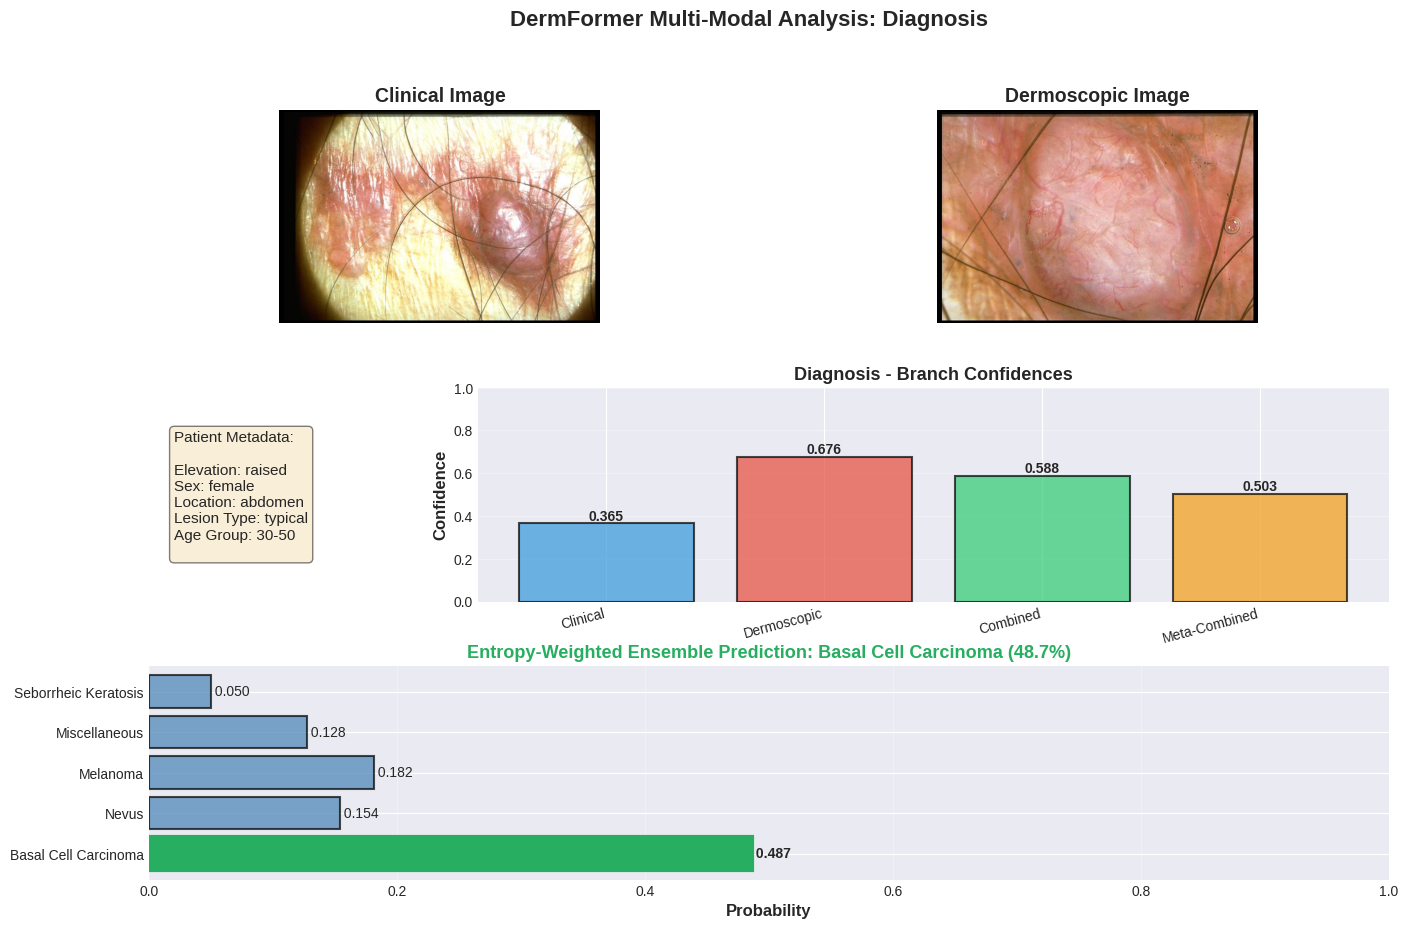

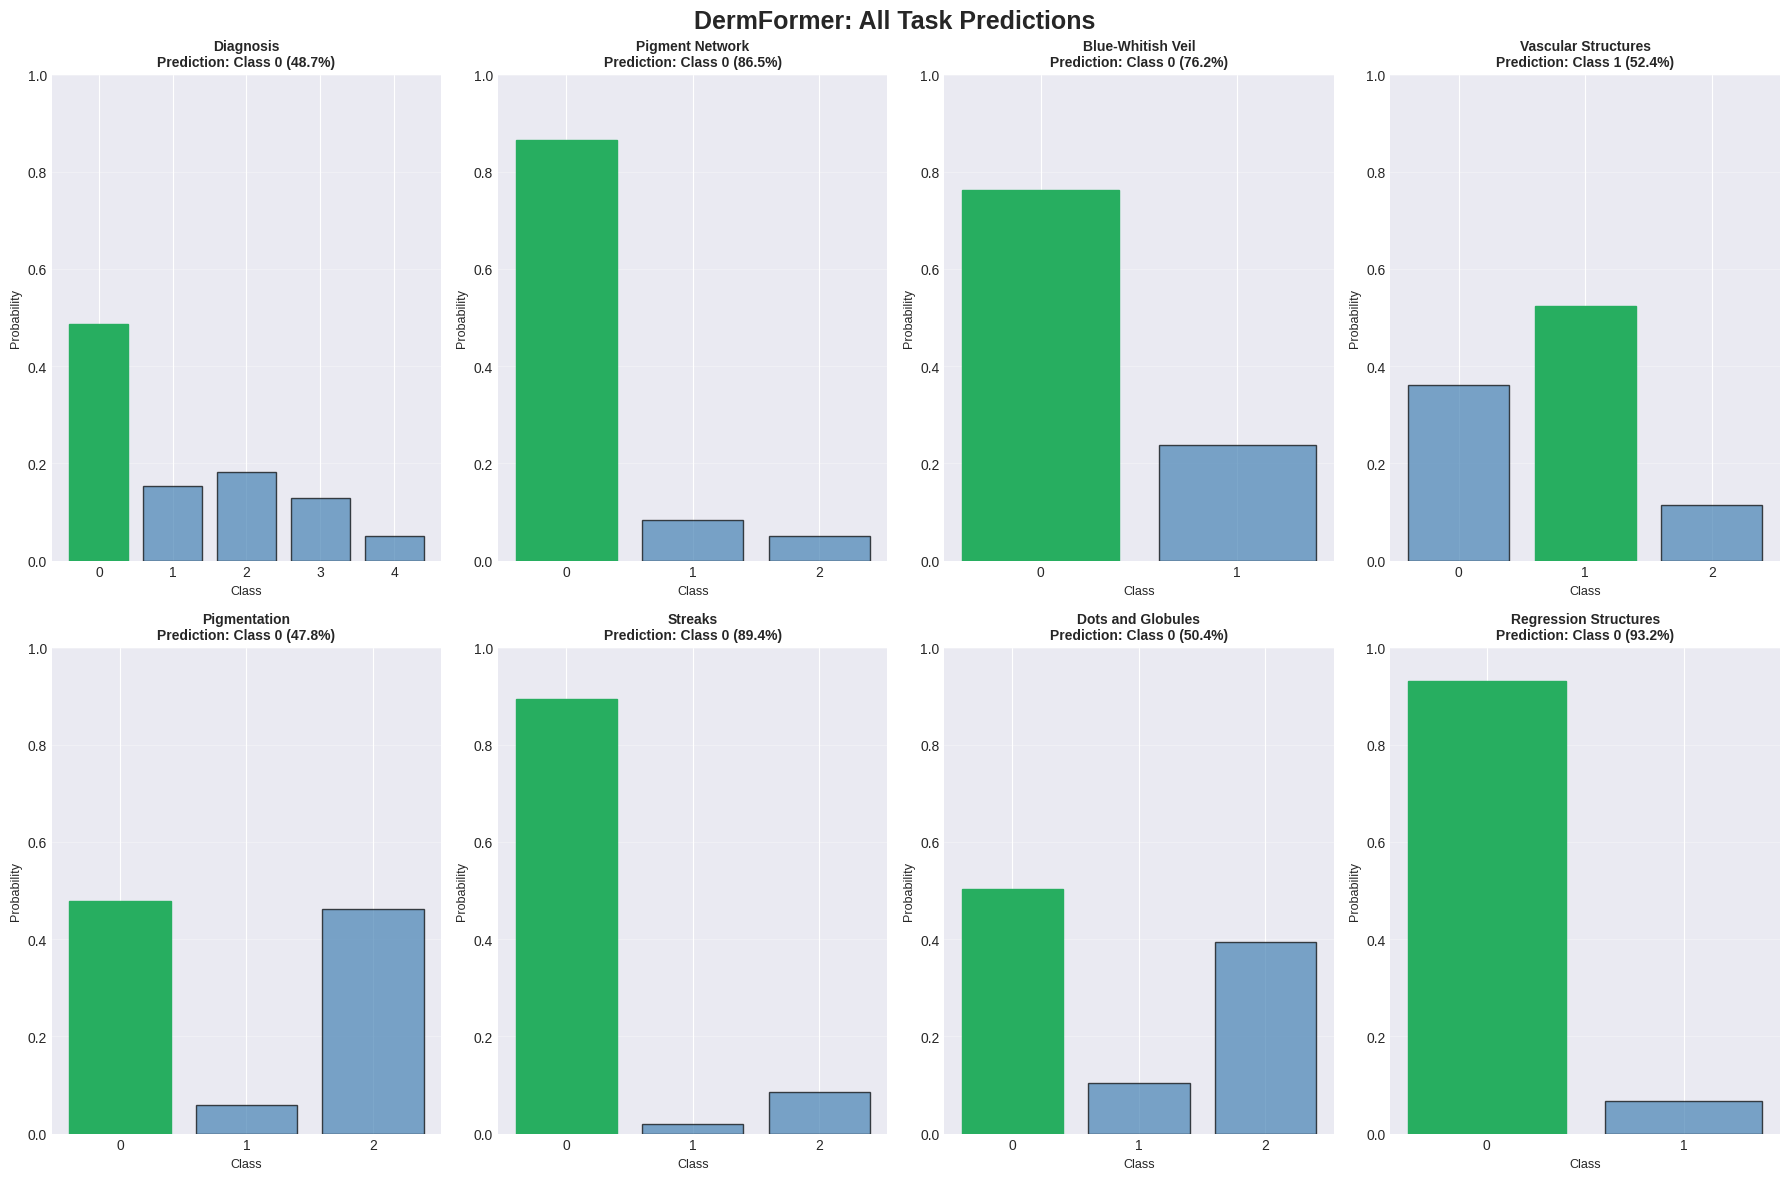

In [7]:
import json

# Load demo cases from extracted metadata
with open('sample_data/cases_metadata.json', 'r') as f:
    demo_cases = json.load(f)

print(f"Loaded {len(demo_cases)} demo cases:")
for case in demo_cases:
    print(f"   • Case {case['case_num']}: {case['diagnosis']}")

# Select first case (Basal Cell Carcinoma)
case = demo_cases[0]

# Extract paths and metadata
SAMPLE_CLINICAL_IMG = f'sample_data/{case["clinical_img"]}'
SAMPLE_DERMOSCOPIC_IMG = f'sample_data/{case["dermoscopic_img"]}'
metadata = case['metadata']

print(f"\nRunning inference on: {case['diagnosis']}")
print(f"   Clinical: {SAMPLE_CLINICAL_IMG}")
print(f"   Dermoscopic: {SAMPLE_DERMOSCOPIC_IMG}")
print(f"   Metadata: {metadata}")
print(f"   Ground Truth Features: {case['clinical_features']}")

# Run inference
results = predict(SAMPLE_CLINICAL_IMG, SAMPLE_DERMOSCOPIC_IMG, metadata)

# Visualize diagnosis prediction
fig = visualize_prediction(results, task='diag')
plt.show()

# Visualize all tasks
fig_all = visualize_all_tasks(results)
plt.show()


Case 1 (1/3): Basal Cell Carcinoma
Patient: female, 30-50
Location: abdomen, Elevation: raised
Ground Truth Features:
   • seven_point: 0
   • vascular_structures: arborizing


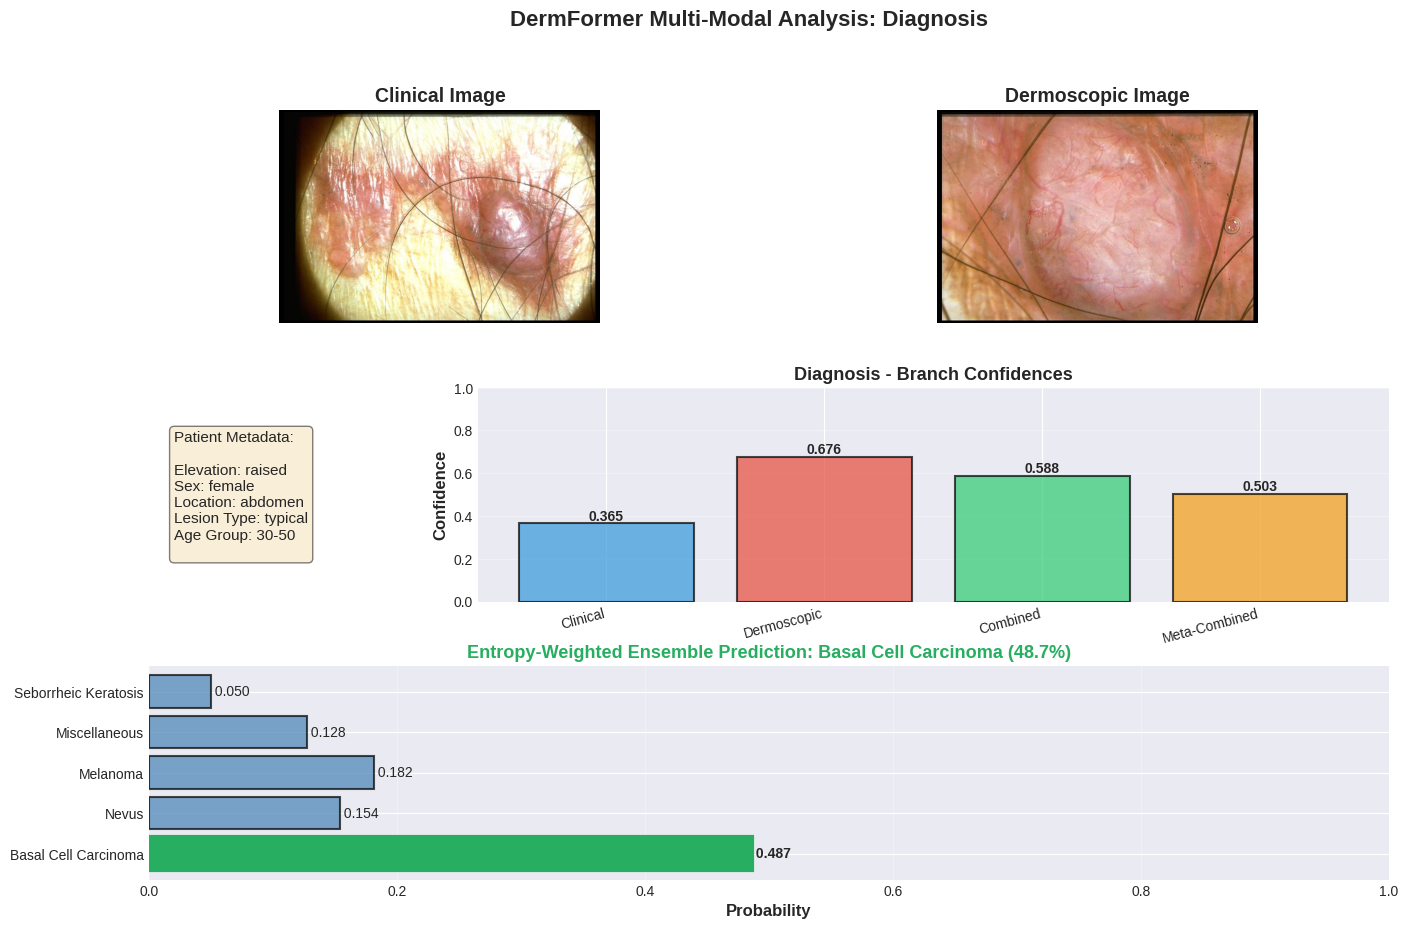


Prediction: Basal Cell Carcinoma (48.7%) | Ground Truth: Basal Cell Carcinoma [CORRECT]


Case 577 (2/3): Melanoma
Patient: female, 30-50
Location: upper extremity, Elevation: raised
Ground Truth Features:
   • seven_point: 3
   • streaks: irregular
   • regression: combination
   • dots_and_globules: irregular


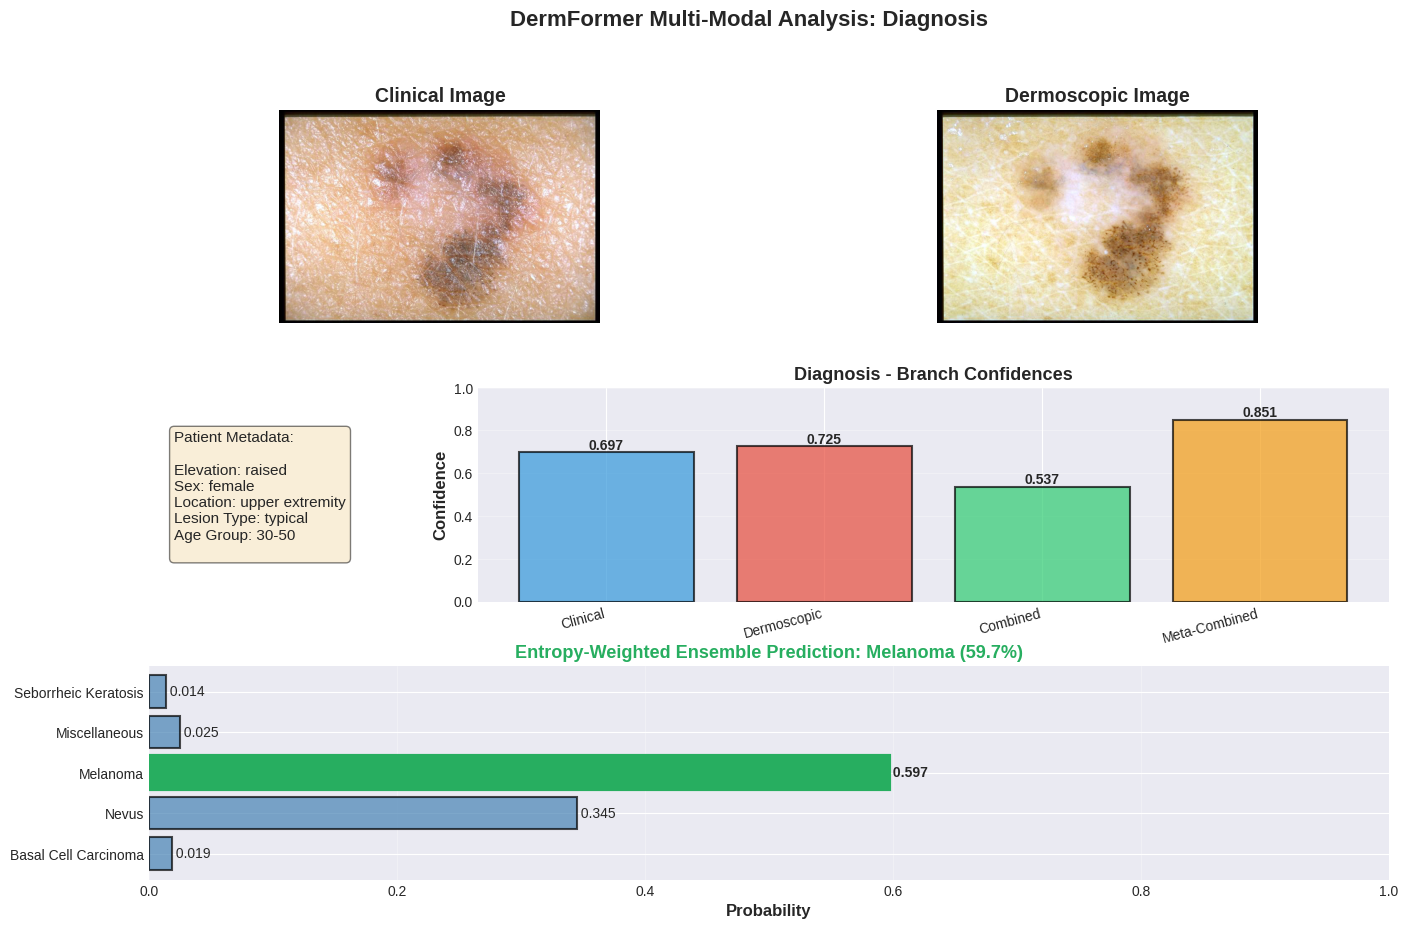


Prediction: Melanoma (59.7%) | Ground Truth: Melanoma [CORRECT]


Case 578 (3/3): Melanoma
Patient: female, 30-50
Location: lower extremity, Elevation: raised
Ground Truth Features:
   • seven_point: 7
   • pigment_network: atypical
   • streaks: irregular
   • pigmentation: localized in
   • dots_and_globules: irregular
   • blue_whitish_veil: present


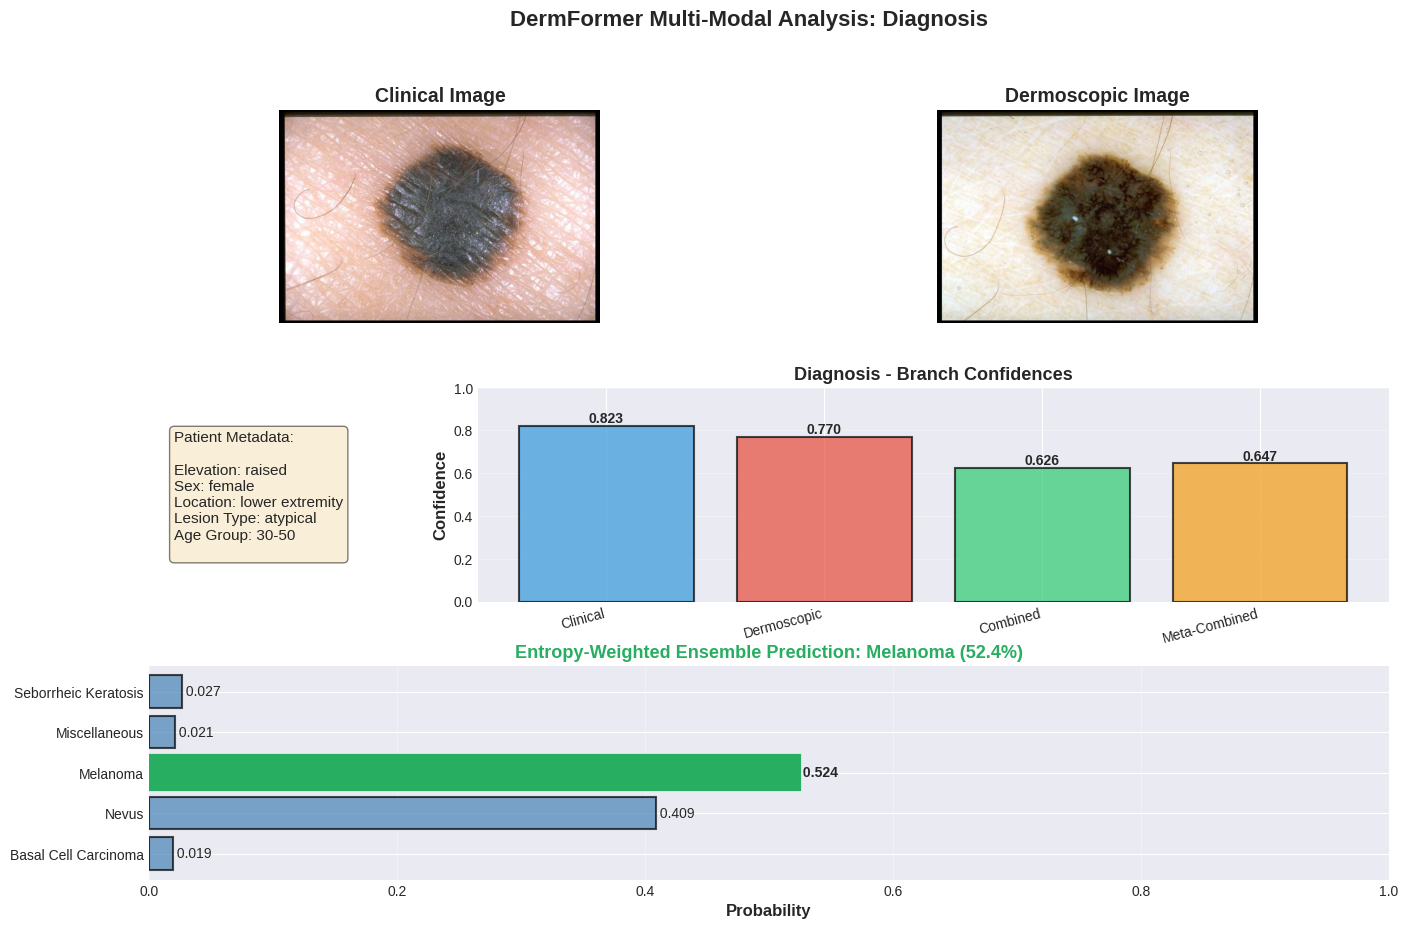


Prediction: Melanoma (52.4%) | Ground Truth: Melanoma [CORRECT]



In [8]:
# Run inference on all demo cases
for idx, case in enumerate(demo_cases):
    clinical_path = f'sample_data/{case["clinical_img"]}'
    dermo_path = f'sample_data/{case["dermoscopic_img"]}'
    
    results = predict(clinical_path, dermo_path, case['metadata'])
    
    print(f"\n{'='*80}")
    print(f"Case {case['case_num']} ({idx+1}/{len(demo_cases)}): {case['diagnosis']}")
    print(f"Patient: {case['metadata']['sex']}, {case['metadata']['age_group']}")
    print(f"Location: {case['metadata']['location']}, Elevation: {case['metadata']['elevation']}")
    print(f"Ground Truth Features:")
    for feature, value in case['clinical_features'].items():
        if value not in ['unknown', 'absent']:
            print(f"   • {feature}: {value}")
    print(f"{'='*80}")
    
    # Visualize diagnosis for this case
    visualize_prediction(results, task='diag')
    plt.show()
    
    # Optionally visualize all tasks (comment out if too many plots)
    # visualize_all_tasks(results)
    # plt.show()
    
    # Compare ensemble prediction with ground truth diagnosis
    pred_idx = results['predictions']['diag']['ensemble']['prediction']
    pred_label = DIAGNOSIS_LABELS[pred_idx]
    pred_conf = results['predictions']['diag']['ensemble']['probabilities'][pred_idx]
    
    match = "CORRECT" if pred_label == case['diagnosis'] else "INCORRECT"
    print(f"\nPrediction: {pred_label} ({pred_conf:.1%}) | Ground Truth: {case['diagnosis']} [{match}]\n")

### 7.1 Run Inference on All Demo Cases

Compare predictions across different diagnoses.

## 8. Interactive Widget (Optional)

Create an interactive interface for uploading images and getting predictions.

In [9]:
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    
    # Create widgets
    elevation_dropdown = widgets.Dropdown(options=['flat', 'raised', 'unknown'], value='unknown', description='Elevation:')
    sex_dropdown = widgets.Dropdown(options=['male', 'female', 'unknown'], value='unknown', description='Sex:')
    location_dropdown = widgets.Dropdown(
        options=['back', 'lower extremity', 'abdomen', 'face', 'chest', 'upper extremity', 'scalp', 'neck', 'unknown'],
        value='unknown', description='Location:'
    )
    lesion_dropdown = widgets.Dropdown(options=['typical', 'atypical'], value='typical', description='Lesion Type:')
    age_dropdown = widgets.Dropdown(options=['<30', '30-50', '>50'], value='30-50', description='Age Group:')
    
    task_dropdown = widgets.Dropdown(
        options=list(TASK_LABELS.keys()),
        value='diag',
        description='Task:'
    )
    
    print("Interactive widgets ready! (Note: File upload requires manual path specification)")
    
except ImportError:
    print("Warning: ipywidgets not available. Install with: pip install ipywidgets")

Interactive widgets ready! (Note: File upload requires manual path specification)


## 9. Model Interpretation: Branch Analysis

Analyze how each branch (Clinical, Dermoscopic, Combined, Meta-Combined) contributes to the final prediction.

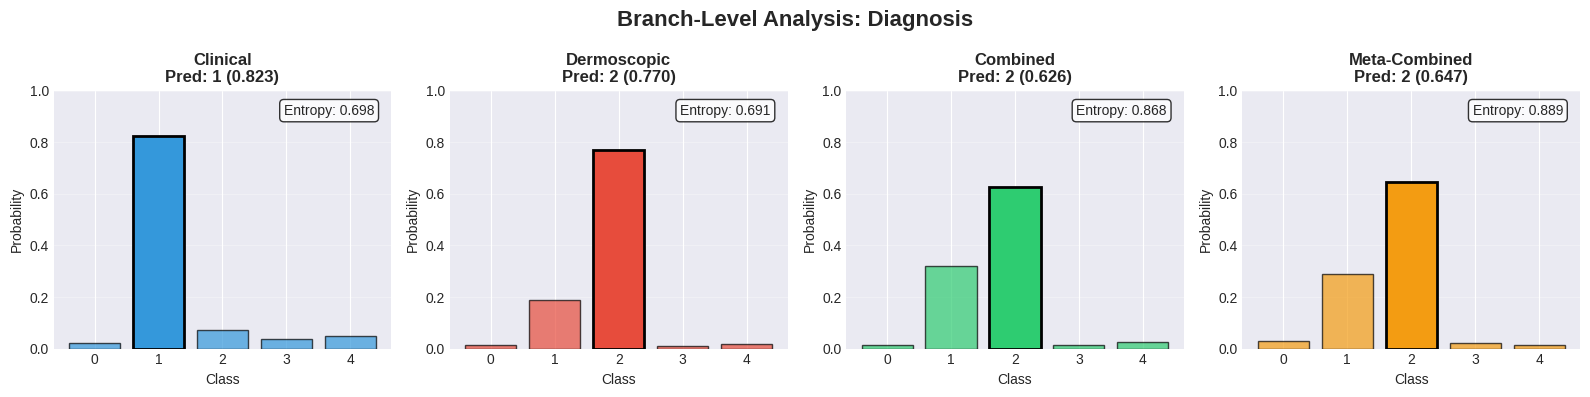

In [10]:
def analyze_branch_contributions(results, task='diag'):
    """
    Analyze and visualize branch contributions to ensemble prediction.
    """
    pred_data = results['predictions'][task]
    branches = pred_data['branches']
    ensemble = pred_data['ensemble']
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle(f'Branch-Level Analysis: {TASK_LABELS[task]}', fontsize=16, fontweight='bold')
    
    branch_names = list(branches.keys())
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    
    for idx, (branch_name, ax, color) in enumerate(zip(branch_names, axes, colors)):
        branch_data = branches[branch_name]
        probs = branch_data['probabilities']
        pred = branch_data['prediction']
        
        # Plot probabilities
        bars = ax.bar(range(len(probs)), probs, color=color, alpha=0.7, edgecolor='black')
        bars[pred].set_alpha(1.0)
        bars[pred].set_linewidth(2)
        
        ax.set_title(f'{branch_name}\nPred: {pred} ({probs[pred]:.3f})', fontweight='bold')
        ax.set_xlabel('Class')
        ax.set_ylabel('Probability')
        ax.set_ylim([0, 1])
        ax.grid(axis='y', alpha=0.3)
        
        # Add entropy indicator
        entropy = -np.sum(probs * np.log(probs + 1e-10))
        ax.text(0.95, 0.95, f'Entropy: {entropy:.3f}',
               transform=ax.transAxes, ha='right', va='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

# Run analysis on previous results
if 'results' in locals():
    fig = analyze_branch_contributions(results, task='diag')
    plt.show()
else:
    print("Run inference first (Section 7) to generate results.")

## 10. Entropy-Weighted Ensemble Explanation

Demonstrate how the model uses entropy (uncertainty) to weight different branches.


ENTROPY-WEIGHTED ENSEMBLE EXPLANATION

Task: Diagnosis

Clinical        | Entropy: 0.698 | Weight: 0.259 | Confidence: 0.823
Dermoscopic     | Entropy: 0.691 | Weight: 0.260 | Confidence: 0.770
Combined        | Entropy: 0.868 | Weight: 0.241 | Confidence: 0.626
Meta-Combined   | Entropy: 0.889 | Weight: 0.239 | Confidence: 0.647

Note: Lower entropy = More confident = Higher weight in ensemble



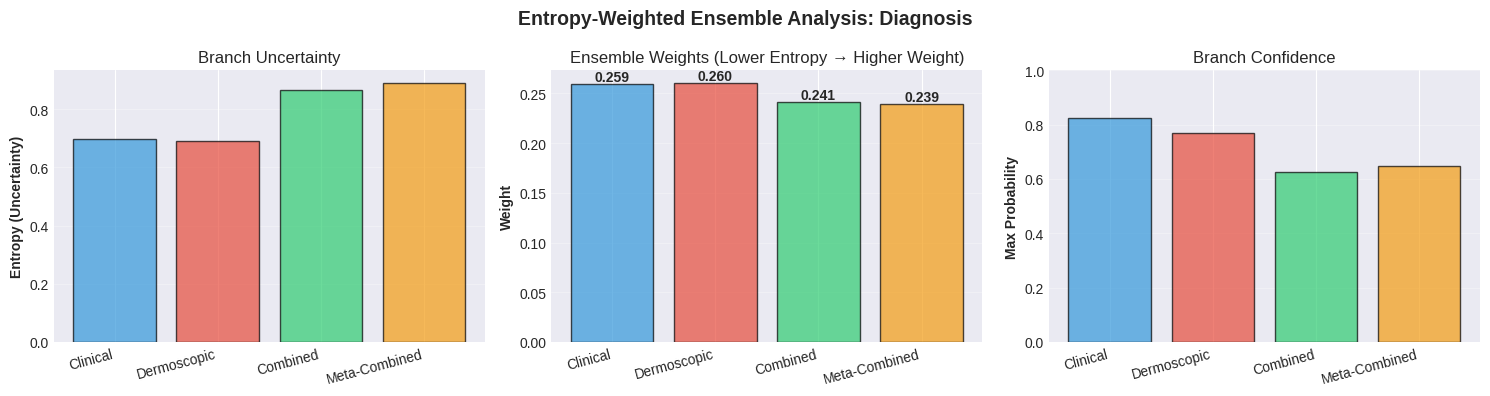

In [11]:
def visualize_entropy_weighting(results, task='diag'):
    """
    Visualize how entropy affects branch weighting in the ensemble.
    """
    pred_data = results['predictions'][task]
    branches = pred_data['branches']
    
    # Calculate entropy for each branch
    branch_names = list(branches.keys())
    entropies = []
    confidences = []
    
    for branch_name in branch_names:
        probs = branches[branch_name]['probabilities']
        entropy = -np.sum(probs * np.log(probs + 1e-10))
        confidence = probs.max()
        entropies.append(entropy)
        confidences.append(confidence)
    
    # Calculate weights (inverse of entropy)
    total_entropy = sum(entropies)
    weights = [(1 - e/total_entropy) for e in entropies]
    weights = np.array(weights) / sum(weights)  # Normalize
    
    # Visualization
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'Entropy-Weighted Ensemble Analysis: {TASK_LABELS[task]}', fontsize=14, fontweight='bold')
    
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    x_pos = np.arange(len(branch_names))
    
    # Plot 1: Entropy
    bars1 = ax1.bar(x_pos, entropies, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Entropy (Uncertainty)', fontweight='bold')
    ax1.set_title('Branch Uncertainty')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(branch_names, rotation=15, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: Weights
    bars2 = ax2.bar(x_pos, weights, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Weight', fontweight='bold')
    ax2.set_title('Ensemble Weights (Lower Entropy → Higher Weight)')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(branch_names, rotation=15, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, weight in zip(bars2, weights):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{weight:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Confidence
    bars3 = ax3.bar(x_pos, confidences, color=colors, alpha=0.7, edgecolor='black')
    ax3.set_ylabel('Max Probability', fontweight='bold')
    ax3.set_title('Branch Confidence')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(branch_names, rotation=15, ha='right')
    ax3.set_ylim([0, 1])
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # Print explanation
    print("\n" + "="*80)
    print("ENTROPY-WEIGHTED ENSEMBLE EXPLANATION")
    print("="*80)
    print(f"\nTask: {TASK_LABELS[task]}\n")
    for i, name in enumerate(branch_names):
        print(f"{name:15s} | Entropy: {entropies[i]:.3f} | Weight: {weights[i]:.3f} | Confidence: {confidences[i]:.3f}")
    print("\nNote: Lower entropy = More confident = Higher weight in ensemble")
    print("="*80 + "\n")
    
    return fig

# Run analysis
if 'results' in locals():
    fig = visualize_entropy_weighting(results, task='diag')
    plt.show()
else:
    print("Run inference first (Section 7) to generate results.")

## 11. Model Performance Summary

Display key performance metrics from training.

In [12]:
performance_summary = """
╔═══════════════════════════════════════════════════════════╗
║           DermFormer Performance Summary                  ║
╠═══════════════════════════════════════════════════════════╣
║  Dataset:                Derm7pt                          ║
║  Training Cases:         413                              ║
║  Validation Cases:       203                              ║
║  Test Cases:             395                              ║
║                                                           ║
║  Best Epoch:             97                               ║
║  Total Epochs:           147 (early stopping)             ║
║  Training Time:          ~42 minutes                      ║
║                                                           ║
║  Final Validation Acc:   74.08%                           ║
║  Test Accuracy:          76.68%                           ║
║                                                           ║
║  Model Size:             211 MB                           ║
║  Parameters:             ~52M trainable                   ║
║                                                           ║
║  Architecture:           Multi-Modal NeST + TabTransformer║
║  Key Innovation:         Entropy-weighted ensemble        ║
╚═══════════════════════════════════════════════════════════╝
"""

print(performance_summary)

# Model architecture diagram
architecture_flow = """
┌─────────────────────────────────────────────────────────────┐
│                   DermFormer Architecture                   │
└─────────────────────────────────────────────────────────────┘

    Clinical Image          Dermoscopic Image      Metadata
         │                         │                  │
         ▼                         ▼                  ▼
   ┌──────────┐              ┌──────────┐       ┌──────────┐
   │ NeST-CLI │              │ NeST-DER │       │   Tab    │
   │ Encoder  │              │ Encoder  │       │Transform │
   └──────────┘              └──────────┘       └──────────┘
         │                         │                  │
         └──────────┬──────────────┘                  │
                    ▼                                 │
            ┌───────────────┐                         │
            │ Context Nest  │                         │
            │  (Combined)   │                         │
            └───────────────┘                         │
                    │                                 │
         ┌──────────┴──────────┐                     │
         ▼                     ▼                     ▼
   ┌──────────┐         ┌──────────┐         ┌──────────┐
   │  Cross   │         │  Cross   │         │  Fusion  │
   │Attention │         │Attention │         │  Layer   │
   │ CLI-CTX  │         │ DER-CTX  │         │          │
   └──────────┘         └──────────┘         └──────────┘
         │                     │                     │
         └──────────┬──────────┴─────────────────────┘
                    ▼
         ┌────────────────────┐
         │ Entropy-Weighted   │
         │ Ensemble Voting    │
         └────────────────────┘
                    │
                    ▼
         ┌────────────────────┐
         │  8 Task Outputs:   │
         │  • Diagnosis       │
         │  • Pigment Network │
         │  • Blue-White Veil │
         │  • Vascular Struct │
         │  • Pigmentation    │
         │  • Streaks         │
         │  • Dots & Globules │
         │  • Regression      │
         └────────────────────┘
"""

print(architecture_flow)


╔═══════════════════════════════════════════════════════════╗
║           DermFormer Performance Summary                  ║
╠═══════════════════════════════════════════════════════════╣
║  Dataset:                Derm7pt                          ║
║  Training Cases:         413                              ║
║  Validation Cases:       203                              ║
║  Test Cases:             395                              ║
║                                                           ║
║  Best Epoch:             97                               ║
║  Total Epochs:           147 (early stopping)             ║
║  Training Time:          ~42 minutes                      ║
║                                                           ║
║  Final Validation Acc:   74.08%                           ║
║  Test Accuracy:          76.68%                           ║
║                                                           ║
║  Model Size:             211 MB                           ║
║  Para

## 12. Conclusion and Key Takeaways

This notebook demonstrates:

### Technical Skills Showcased
- Deep learning model implementation and training
- Multi-modal data fusion and cross-attention mechanisms
- Ensemble learning with uncertainty quantification
- Medical image analysis and computer vision
- PyTorch optimization and GPU acceleration

### Novel Contributions
- Entropy-weighted ensemble voting for robust predictions
- Cross-attention fusion of clinical, dermoscopic, and metadata
- Multi-task learning for comprehensive lesion characterization

### Results
- **76.68% test accuracy** on Derm7pt benchmark
- Interpretable predictions with branch-level analysis
- Production-ready model with efficient inference

### Applications
- Clinical decision support for dermatologists
- Teledermatology screening
- Educational tool for medical training
- Research platform for multi-modal fusion studies

---

**Author**: Matthew Cockayne  
**Contact**: https://matt-cockayne.github.io
**GitHub**: https://github.com/Matt-Cockayne
**Date**: 2025  

*This work is part of my PhD research portfolio demonstrating expertise in deep learning, medical imaging, and production ML systems.*